<a href="https://colab.research.google.com/github/ArturSViana/Previsao-Consumo-Energia--Temporal-Series-/blob/main/Previs%C3%A3o_de_consumo_de_energia_el%C3%A9trica_(TS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install pmdarima
!pip install xgboost

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artursilveiraviana","key":"cdba227a35eec0026b3497797ad63151"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from xgboost import XGBRegressor

In [ ]:
kaggle.api.authenticate()

In [ ]:
kaggle.api.dataset_download_files('shenba/time-series-datasets', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/shenba/time-series-datasets


In [ ]:
df = pd.read_csv('./data/Electric_Production.csv', index_col='DATE', parse_dates=True)
df.columns = ['consumo']
df.head()

,consumo
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.describe()

,consumo
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [ ]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

<Axes: xlabel='DATE'>

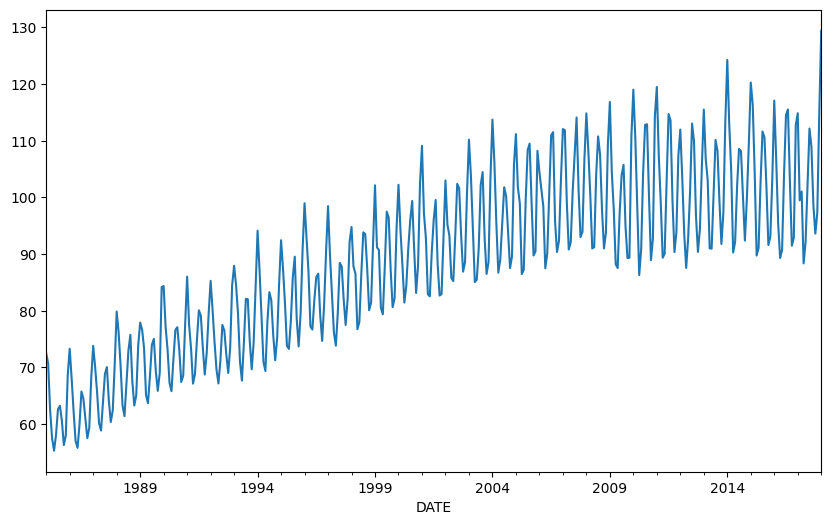

In [ ]:
df['consumo'].plot(figsize=(10, 6))

# Prevendo com XGBoost

### Separando dados de Treino e Validação

In [ ]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (13, 1))

In [ ]:
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [ ]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

### Criando TARGET e LAGGED VARIABLE

In [ ]:
treino['consumo']

,consumo
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2016-08-01,115.5159
2016-09-01,102.7637
2016-10-01,91.4867


In [ ]:
treino['target'] = treino['consumo'].shift(-1)
treino.head()

<ipython-input-18-47b9cd1c1233>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['consumo'].shift(-1)


,consumo,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [ ]:
treino = treino.dropna()
treino.tail()

,consumo,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [ ]:
validacao['target'] = validacao['consumo'].shift(-1)
validacao = validacao.dropna()
validacao.tail()

<ipython-input-22-620d5b5db3fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['target'] = validacao['consumo'].shift(-1)


,consumo,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048


### Treinando o Modelo

In [ ]:
X_treino = treino.drop('target', axis=1).values
y_treino = treino[['target']].values
X_validacao = validacao.drop('target', axis=1).values
y_validacao = validacao[['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (12, 1), (12, 1))

In [ ]:
modelo_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=2000)
modelo_xgb.fit(X_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
validacao.iloc[-1]

,2017-12-01
consumo,114.7212
target,129.4048


In [ ]:
predicao = modelo_xgb.predict(X_validacao[-1])
predicao

array([114.556244], dtype=float32)

# Criando estrutura para prever vários dias (modelos individuais)

In [ ]:
n= len(validacao)
previsoes =[]
index_lista = []
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']


for i in range(1, n):

  treino_copy = treino.copy()
  validacao_copy = validacao.copy()

  treino_copy['target'] = treino_copy['consumo'].shift(-i)
  validacao_copy['target'] = validacao_copy['consumo'].shift(-i)
  treino_copy = treino_copy.dropna()
  validacao_copy = validacao_copy.dropna()

  X_treino_copy = treino_copy.drop('target', axis=1).values
  y_treino_copy = treino_copy[['target']].values
  X_validacao_copy = validacao_copy.drop('target', axis=1).values
  y_validacao_copy = validacao_copy[['target']].values

  print(f'Treinando modelo {i} mes')
  modelo_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
  modelo_xgb.fit(X_treino_copy, y_treino_copy)
  print(f'Prevendo consumo {i} mes a frente')
  previsao = modelo_xgb.predict(X_validacao_copy[0])
  print(previsao)
  print(validacao.index[i])
  print('-'*100)


  index_lista.append(validacao.index[i])
  previsoes.append(previsao[0])

previsoes_st = pd.Series(previsoes, index_lista)
# print(previsoes_st)

previsao_df = validacao.copy()
previsao_df['previsao'] = previsoes_st
# print(previsao_df)




Treinando modelo 1 mes
Prevendo consumo 1 mes a frente
[108.23326]
2017-02-01 00:00:00
----------------------------------------------------------------------------------------------------
Treinando modelo 2 mes
Prevendo consumo 2 mes a frente
[100.438644]
2017-03-01 00:00:00
----------------------------------------------------------------------------------------------------
Treinando modelo 3 mes
Prevendo consumo 3 mes a frente
[90.994385]
2017-04-01 00:00:00
----------------------------------------------------------------------------------------------------
Treinando modelo 4 mes
Prevendo consumo 4 mes a frente
[91.23663]
2017-05-01 00:00:00
----------------------------------------------------------------------------------------------------
Treinando modelo 5 mes
Prevendo consumo 5 mes a frente
[102.32775]
2017-06-01 00:00:00
----------------------------------------------------------------------------------------------------
Treinando modelo 6 mes
Prevendo consumo 6 mes a frente
[110.

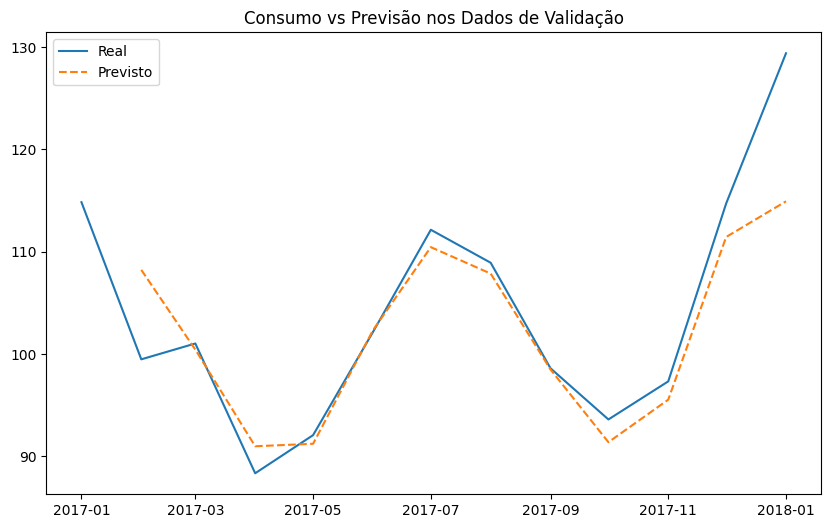

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Consumo vs Previsão nos Dados de Validação')
plt.plot(previsao_df['consumo'], label='Real')
plt.plot(previsao_df['previsao'], label='Previsto', linestyle='--')
plt.legend()

# Medindo performance do modelo

In [ ]:
from sklearn.metrics import mean_squared_error
previsao_df = previsao_df.dropna()
mse = mean_squared_error(previsao_df['consumo'], previsao_df['previsao'])
print(f'MSE: {mse}')

MSE: 26.400845489193404
